### Hyperparameters to reproduce results of paper "Computing the untruncated signature kernel..."

In [97]:
name, sigma, ll, at = 'ArticularyWordRecognition', 6e-1, False, False
# name, scale, rbf, sigma, ll, at = 'BasicMotions', 1e-1, True, 7e1, False, False
# name, scale, rbf, sigma, ll, at = 'Cricket', 1e-1, True, 1e0, False, False # subsample_len every 10 time steps
# name, scale, rbf, sigma, ll, at = 'Epilepsy', 1e-1, True, 1e0, False, False
# name, scale, rbf, sigma, ll, at = 'ERing', 1e-2, True, 9e-2, False, True
# name, scale, rbf, sigma, ll, at = 'Heartbeat', 1e-1, True, 1e1, False, True
# name, scale, rbf, sigma, ll, at = 'Libras', 1e-1, True, 3e-2, False, False
# name, scale, rbf, sigma, ll, at = 'NATOPS', 1e-1, True, 2.25e-1, False, True
# name, scale, rbf, sigma, ll, at = 'RacketSports', 1e-1, True, 1e1, False, False
# name, scale, rbf, sigma, ll, at = 'SelfRegulationSCP1', 1e-1, True, 2.5e2, False, False # subsample_len every 2 time steps
# name, scale, rbf, sigma, ll, at = 'UWaveGestureLibrary', 1e0, True, 3.5e1, False, True # subsample_len every 5 time steps
# name, scale, rbf, sigma, ll, at = 'ElectricDevices', 1e0, False, 3.5e1, False, True

In [94]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import iisignature
import torch 

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from tslearn.svm import TimeSeriesSVC

import sigkernel

In [9]:
# store classification results
final_results = {}

for name in tqdm(list_datasets, desc='1st loop (datasets)'):
    
    # load data
    X_train, Y_train, X_test, Y_test = UCR_UEA_datasets(use_cache=True).load_dataset(name)

    # standard-scale inputs
    x_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
    x_test = TimeSeriesScalerMeanVariance().fit_transform(X_test)
    
    # encode outputs as labels
    y_train = LabelEncoder().fit_transform(y_train)
    y_test = LabelEncoder().fit_transform(y_test)

    for at in tqdm([True, False], desc='2nd loop (add-time)', leave=False):
        for ll in tqdm([True, False], desc='3rd loop (lead-lag)', leave=False):

            # path-transforms
            x_train = sigkernel.transform(x_train, at, ll)
            x_test = sigkernel.transform(x_test, at, ll)

            # move to torch
            x_train = sigkernel.transform(x_train, at, ll, scale=.1)
            x_test = sigkernel.transform(x_test, at, ll, scale=.1)
            
            # define grid-search hyperparameters for SVC (common to all kernels)
            svc_parameters = {'C': np.logspace(0, 4, 5), 'gamma': np.logspace(-3, 3, 7)}
            
            #==================================================================================
            # Linear, RBF and GAK kernels
            #==================================================================================
            for ker in tqdm(['linear', 'rbf', 'gak'], desc='4th loop (standard kernels)', leave=False):

                # SVC tslearn estimator
                svc = TimeSeriesSVC(kernel=ker, gamma='auto', decision_function_shape='ovo')
                svc_model = GridSearchCV(estimator=svc, param_grid=svc_parameters, cv=TimeSeriesSplit(n_splits=5), n_jobs=-1)
                svc_model.fit(x_train, y_train)
                
                # store results
                final[(ker, f'add-time: {at}', f'lead-lag: {ll}')] = svc_model.score(x_test, y_test)
                
            #==================================================================================
            # Truncated signature kernel
            #==================================================================================
            # set max signature truncation
            max_depth = 7 if x_train.shape[-1] < 10 else 6
            
            for d in tqdm(range(2,max_depth), desc='4th loop (truncated sig kernels)', leave=False):
                
                # truncated signatures
                sig_train = iisignature.sig(x_train, d)
                sig_test = iisignature.sig(x_test, d)
                
                # SVC tslearn estimator
                svc = TimeSeriesSVC(kernel='linear', decision_function_shape='ovo')
                svc_model = GridSearchCV(estimator=svc, param_grid=svc_parameters, cv=5, n_jobs=-1)
                svc_model.fit(sig_train, y_train)
                
                # store results
                final[(f'trunc-sig-ker-{d}', f'add-time: {at}', f'lead-lag: {ll}')] = svc_model.score(sig_test, y_test)
            
            #==================================================================================
            # Signature PDE kernel
            #==================================================================================
            sigmas = list(np.linspace(0,1,41)[1:]) + [1.] + list(np.linspace(0,200,41)[1:])
            best_score, best_sigma = 0., 0.
            for sigma in tqdm(sigmas, desc='4th loop (sigmas sig PDE kernel)', leave=False):
                
                # define static kernel
                static_kernel = sigkernel.RBFKernel(sigma=sigma)

                # initialize corresponding signature PDE kernel
                signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=0)

                # compute Gram matrix on train data
                G_train = signature_kernel.compute_Gram(x_train, x_train, sym=True).numpy()

                # compute Gram matrix on test data
                G_test = signature_kernel.compute_Gram(x_test, x_train, sym=True).numpy()

                # SVC sklearn estimator
                svc = TimeSeriesSVC(kernel='precomputed', decision_function_shape='ovo')
                svc_model = GridSearchCV(estimator=svc, param_grid=svc_parameters, cv=5, n_jobs=-1)
                svc_model.fit(G_train, y_train)
                
                # choose best model
                _score = svc_model.score(G_test, y_test)
                if _score > best_score:
                    best_score = _score
                    best_sigma = sigma
                
            # store results
            final[('sig-ker-PDE', f'add-time: {at}', f'lead-lag: {ll}', f'best sigma: {best_sigma}')] = best_score
            
    final_csv = pd.DataFrame.from_dict(final, orient='index').rename(columns={0:'accuracy (%)'})
    final_csv.to_csv(f'../results/_{name}.csv')

In [3]:
X_train, Y_train, X_test, Y_test = UCR_UEA_datasets(use_cache=True).load_dataset(name)

In [60]:
subsample = 20
subsample_len = 10

x_train = X_train[::subsample,::subsample_len,:]
y_train = Y_train[::subsample]
x_test = X_test[::subsample,::subsample_len,:]
y_test = Y_test[::subsample]

# x_train = TimeSeriesScalerMinMax().fit_transform(x_train)
x_train = TimeSeriesScalerMeanVariance().fit_transform(x_train)
# x_test = TimeSeriesScalerMinMax().fit_transform(x_test)
x_test = TimeSeriesScalerMeanVariance().fit_transform(x_test)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

print(x_train.shape)
print(x_test.shape)

(14, 15, 9)
(15, 15, 9)


In [61]:
x_train = sigkernel.transform(x_train, at, ll, scale=.1)
x_test = sigkernel.transform(x_test, at, ll, scale=.1)

0


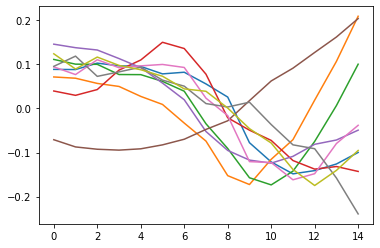

In [62]:
k=0
plt.plot(x_train[k])
print(y_train[k])
plt.show()

In [63]:
x_train = torch.tensor(x_train, dtype=torch.float64)
x_test = torch.tensor(x_test, dtype=torch.float64)

In [64]:
print(f'classes: {np.unique(y_train)}')

classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [65]:
static_kernel = sigkernel.RBFKernel(sigma=sigma)

In [66]:
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=0)

In [67]:
G_train = signature_kernel.compute_Gram(x_train, x_train, sym=True).numpy()

In [73]:
G_test = signature_kernel.compute_Gram(x_test, x_train, sym=False).numpy()

In [74]:
svc_parameters = {'C': np.logspace(0, 3, 4), 'gamma': np.logspace(-3, 3, 7)}

In [75]:
svc = TimeSeriesSVC(kernel='precomputed', decision_function_shape='ovo')

svc_model = GridSearchCV(estimator=svc, 
                         param_grid=svc_parameters, 
                         cv=TimeSeriesSplit(n_splits=5),
                         n_jobs=-1)

In [76]:
svc_model.fit(G_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=TimeSeriesSVC(decision_function_shape='ovo',
                                     kernel='precomputed'),
             n_jobs=-1,
             param_grid={'C': array([   1.,   10.,  100., 1000.]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [90]:
final = {}

In [91]:
# sig-PDE kernel
final[('sig-ker-PDE', f'AddTime: {at}', f'LeadLag: {ll}')] = svc_model.score(G_test, y_test)

In [92]:
final

{('sig-ker-PDE', 'AddTime: False', 'LeadLag: False'): 0.6}

In [1580]:
# linear and rbf kernels
for ker in tqdm.tqdm(['linear', 'rbf']):
    
    svc = TimeSeriesSVC(kernel=ker, gamma='auto', decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)
    
    svc_model.fit(x_train, y_train)
    
    final[ker] = svc_model.score(x_test, y_test)

In [1583]:
# global alignement kernel (GAK)
for gamma in tqdm.tqdm([1., 0.1, 0.01, 'auto']):
            
    svc = TimeSeriesSVC(kernel='gak', gamma=gamma, decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)

    svc_model.fit(x_train, y_train)

    final[f'gak_{gamma}'] = svc_model.score(x_test, y_test)

In [1581]:
# truncated signature kernel
for d in tqdm.tqdm(range(2,5)):
    
    svc = TimeSeriesSVC(kernel='linear', decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)

    sig_train = iisignature.sig(x_train, d)
    sig_test = iisignature.sig(x_test, d)

    svc_model.fit(sig_train, y_train)

    final[f'sig-ker-{d}'] = svc_model.score(sig_test, y_test)

In [1584]:
final

{'sig-ker-PDE': 0.9,
 'linear': 0.79375,
 'rbf': 0.840625,
 'sig-ker-2': 0.809375,
 'sig-ker-3': 0.7625,
 'sig-ker-4': 0.775,
 'gak_1.0': 0.890625,
 'gak_0.1': 0.890625,
 'gak_0.01': 0.890625,
 'gak_auto': 0.890625}

In [1585]:
final_csv = pd.DataFrame.from_dict(final, orient='index').rename(columns={0:'accuracy (%)'})
final_csv.to_csv(f'../results/{name}.csv')